# My first chemistry autoencoder

### Imports

In [1]:
import torch
import torch.nn          as nn
import numpy             as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torch.optim      import Adam

plt.rcParams['figure.dpi'] = 150

### Classes

In [107]:
'''
Class to initialise the dataset to train & test emulator
'''
class MyDataset(Dataset):
    '''
    Get data from textfiles (output CSE model)
    
    Preprocess:
        - set all abundances < cutoff to cutoff
        - take np.log10 of abudances

    '''
    def __init__(self, dir=None, file=None, train=True, fraction=0.7, cutoff = 1e-40):
        data = []

        if dir != None:
            locs = os.listdir(dir) 

            for i in range(1,len(locs)+1):
                name = dir+'csfrac_smooth_'+str(i)+'.out'
                proper = MyDataset.read_data(name)
                data.append(proper)
        
        if file != None:
            proper = MyDataset.read_data(file)
            data.append(proper)

        df = np.concatenate(data)
        df[df < cutoff] = cutoff 
        df = np.log10(df)
        mean = np.mean(df)
        std = np.std(df)
        df = (df-mean)/(2*std)


        self.df = df.astype(np.float32)
        
        N = int(fraction * self.df.shape[0])
        
        if train:
            # Take fraction of the data
            self.df = self.df[:N]
        else:
            # Take 1-fraction of the data 
            self.df = self.df[N:]
            

    def get_mean(self):
        self.df
            
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        return self.df[idx]

    '''
    Read data text file of output abundances of 1D CSE models
    '''
    @staticmethod
    def read_data(file_name):
        with open(file_name, 'r') as file:
            dirty = []
            proper = None
            for line in file:
                try:  
                    if len(line) > 1: 
                        dirty.append([float(el) for el in line.split()])
                except:
                    if len(dirty) != 0:
                        dirty = np.array(dirty)[:,1:]
                        if proper is None:
                            proper = dirty
                        else:
                            proper = np.concatenate((proper, dirty), axis = 1)
                    dirty = []
        return proper

In [3]:
class Encoder(nn.Module):
    """
    Encoder network.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer1 = nn.Linear( input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.layer1(x))
        h = self.LeakyReLU(self.layer2(h))
        h = self.LeakyReLU(self.layer3(h))
        h = self.LeakyReLU(self.layer4(h))
        return h
    
    
class Decoder(nn.Module):
    """
    Decoder network.
    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.layer1 = nn.Linear(latent_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.layer1(x))
        h = self.LeakyReLU(self.layer2(h))
        h = self.LeakyReLU(self.layer3(h))
        h = self.LeakyReLU(self.layer4(h))
        return h
    
    
class Autoencoder(nn.Module):
    """
    Autoencoder.
    """
    def __init__(self, Encoder, Decoder):
        super(Autoencoder, self).__init__()
        
        self.Encoder = Encoder
        self.Decoder = Decoder
                
    def forward(self, x):
        h = self.Encoder(x)
        h = self.Decoder(h)
        return h

### Functions

In [86]:
def plot_hist(df):

    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    for i in range(df.shape[1]):
        ax1.hist(df[:,i].ravel(), bins = 100, histtype='step')

    ax1.set_xlabel('log abundance')
    ax1.set_ylabel('#')

    plt.show()

    return

def plot_loss(train, log = True):
    fig = plt.figure(figsize = (10,4))
    ax1 = fig.add_subplot((111))

    ax1.plot(train, ls = '-'    , c='k', lw = 1)
    ax1.plot(train, ls = None, marker = '.', c='royalblue', label = 'train')

    # ax1.plot(test, ls = '-'    , c='k', lw = 1)
    # ax1.plot(test, ls = None, marker = '.', c='firebrick', label = 'test')

    if log == True:
        ax1.set_yscale('log')

    ax1.set_xlabel('epoch')
    ax1.set_ylabel('MSE')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend(loc = 'upper right')

    plt.show()

    return

def plot_compare(real,pred, specs = None):
    idx = { 'CO'  : 71,
            'H2O' : 36,
            'OH'  : 30,
            'H'   : 0,
            'He'  : 5,
            'HCN' : 59,
            'C2H2': 55,
            'C2H' : 53
            }

    fig = plt.figure(figsize = (5,5))
    ax1 = fig.add_subplot((111))

    if specs == None:
        for spec in idx:
            ax1.scatter(real[:,idx[spec]] ,pred[:,idx[spec]]  , marker = '.', label = spec, alpha = 0.6)
    else:
        for spec in specs:
            ax1.scatter(real[:,idx[spec]] ,pred[:,idx[spec]]  , marker = '.', label = spec, alpha = 0.6)

    ax1.plot([-1,1],[-1,1], '--k', lw = 1)

    ax1.set_xlabel('real')
    ax1.set_ylabel('predicted')

    ax1.grid(True, linestyle = '--', linewidth = 0.2)

    ax1.legend()

    plt.show()


In [5]:
def loss_function(x, x_hat):
    reproduction_loss = nn.functional.mse_loss(x_hat, x)
    return reproduction_loss

### Data: train & test

In [6]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

In [91]:
# Make PyTorch dataset
train = MyDataset(dir=dir)
test  = MyDataset(dir=dir, train = False)

print('# training samples:',len(train))
print('# testing samples:',len(test))


# training samples: 1749
# testing samples: 438


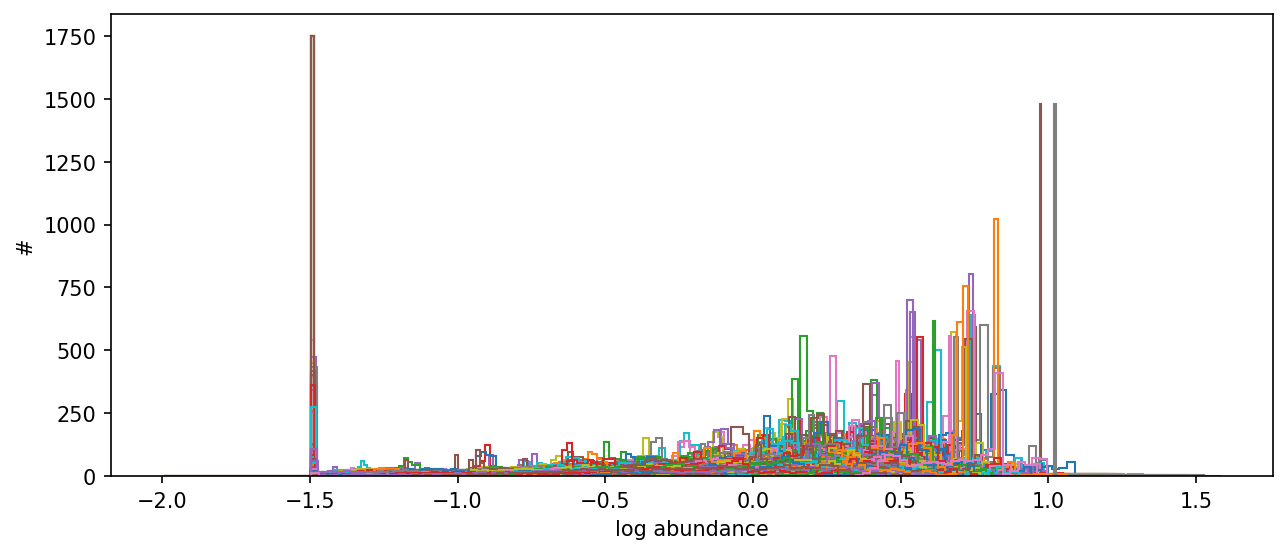

In [92]:
plot_hist(train.df)

### Model hyperparameters

In [93]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

## Set up architecture hyperparams
input_dim  = train.df.shape[1]
hidden_dim = 300
latent_dim = 10
output_dim = input_dim

## Set up training hyperparams
batch_size = 100
lr = 1e-3
epochs = 100

### Training

In [94]:
## Make PyTorch tensor objects from the data set to train

kwargs = {'num_workers': 1, 'pin_memory': True} 

data_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True ,  **kwargs)
test_loader = DataLoader(dataset=train, batch_size=len(test) , shuffle=False,  **kwargs)


In [95]:
## Build model

encoder = Encoder( input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim)

model = Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)        # GPU/TPU/... --> XPU


In [96]:
## Training model

optimizer = Adam(model.parameters(), lr=lr)

model.train()

loss_train = []

for epoch in range(epochs):
    
    overall_loss = 0
    
    for x in data_loader:
           
        x     = x.to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device

        x_hat = model(x)         ## output van het autoecoder model

        ## Calculate losses
        loss  = loss_function(x,x_hat)
        overall_loss += loss.item()

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_train.append(overall_loss)  ## save losses
      
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss , end="\r")

In [97]:
## Testing model

model.eval()


with torch.no_grad():
    loss_test = 0
    for x in test_loader:

        x     = x.to(DEVICE)     ## op een niet-CPU berekenen als dat er is op de device

        x_hat = model(x)         ## output van het autoecoder model

        ## Calculate losses
        loss  = loss_function(x,x_hat)
        loss_test += loss.item()
        

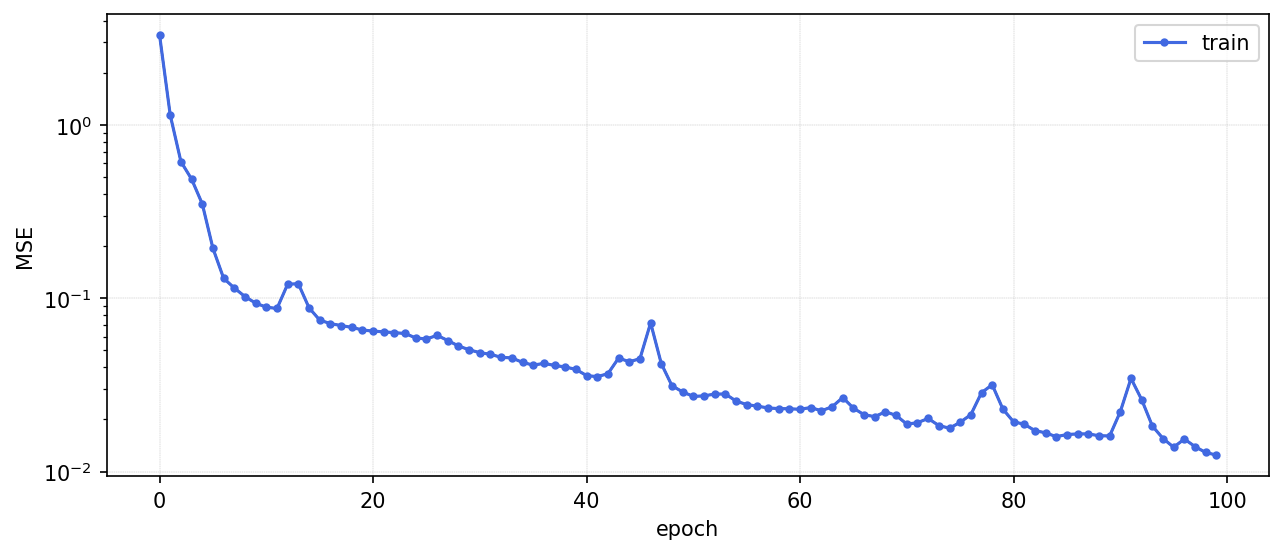

In [98]:
plot_loss(loss_train)

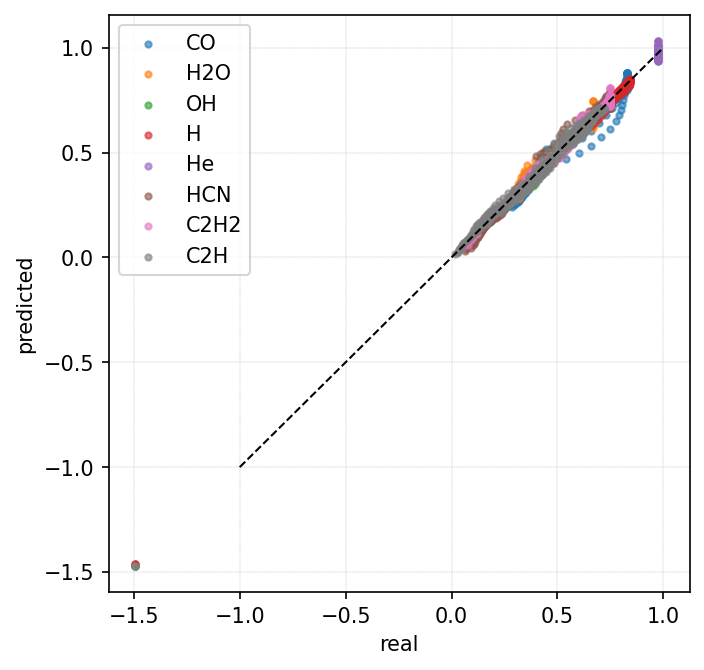

In [106]:
plot_compare(x,x_hat)


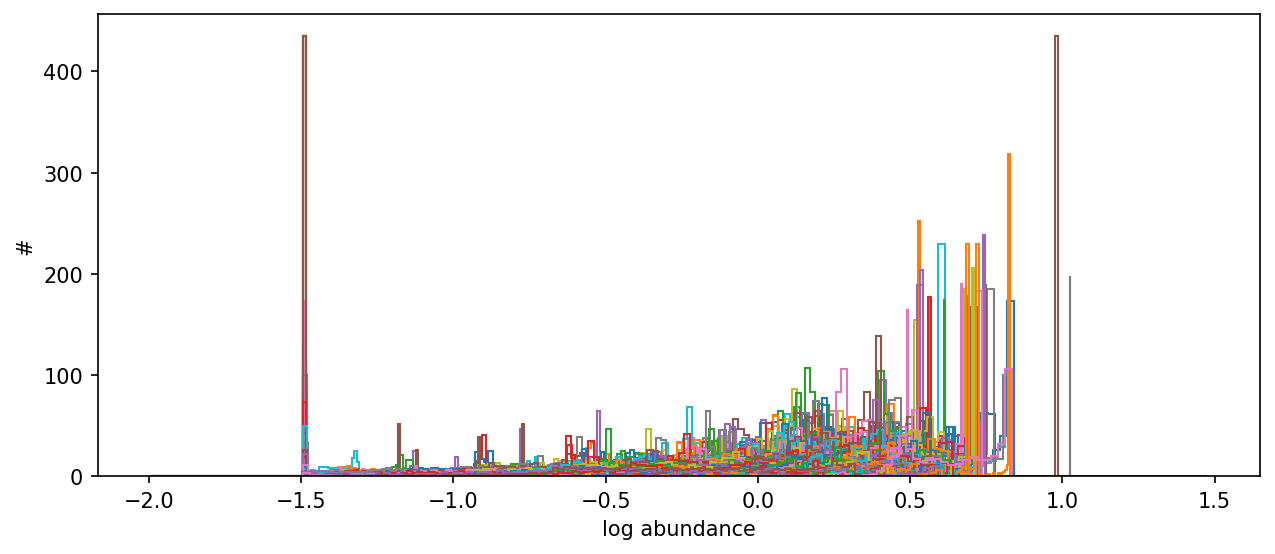

In [103]:
plot_hist(x)

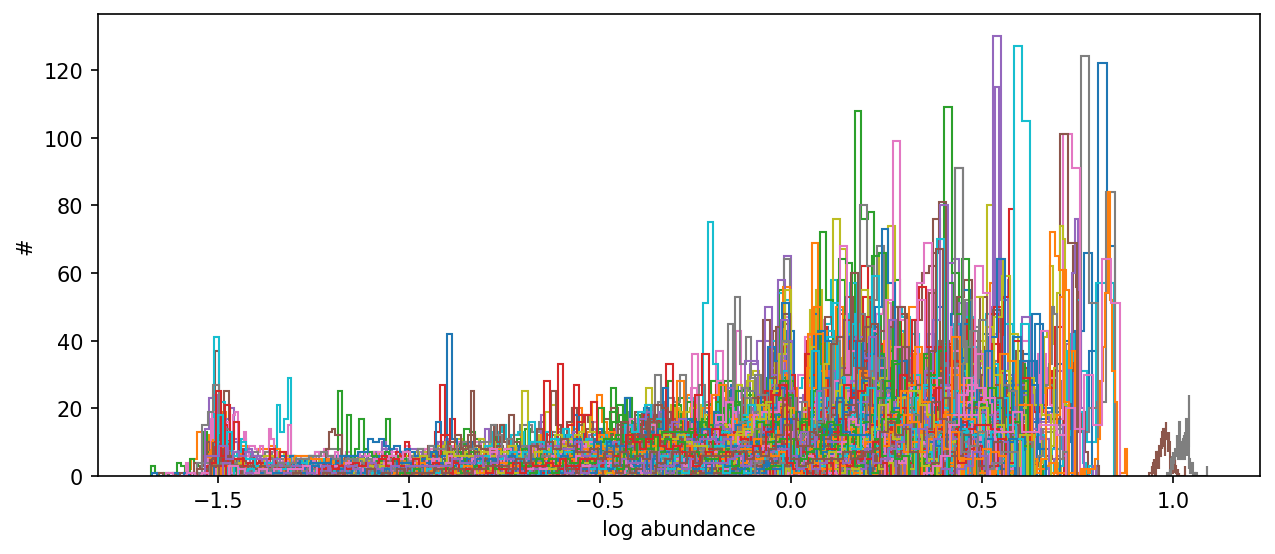

In [104]:
plot_hist(x_hat)

## Visualisation

In [13]:
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

physpar = pd.read_fwf(dir_test+'csphyspar_smooth_test.out', )
test_fracs = MyDataset(file=dir_test+'csfrac_smooth_test.out')

In [14]:
physpar

,RADIUS,n(Htot),TEMP,A_UV EFF,RAD. EFF,C K(PH),C K(IP),C K(AP),CO K(PH),CO K(IP),CO K(AP),DELTA_AUV
0,1.000000e+14,9.016000e+06,1851.0,2.242000,0.03752,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,3.363
1,1.122000e+14,7.162000e+06,1788.0,1.998000,0.05107,1.292000e-11,0.0,0.0,4.212000e-15,0.0,0.0,3.607
2,1.259000e+14,5.689000e+06,1728.0,1.781000,0.06754,1.798000e-11,0.0,0.0,6.387000e-15,0.0,0.0,3.824
3,1.413000e+14,4.519000e+06,1669.0,1.587000,0.08700,2.374000e-11,0.0,0.0,9.164000e-15,0.0,0.0,4.018
4,1.585000e+14,3.590000e+06,1612.0,1.415000,0.10940,3.114000e-11,0.0,0.0,1.320000e-14,0.0,0.0,4.191
...,...,...,...,...,...,...,...,...,...,...,...,...
76,6.310000e+17,2.265000e-01,134.1,0.000355,0.99910,3.497000e-10,0.0,0.0,2.396000e-10,0.0,0.0,5.605
77,7.079000e+17,1.799000e-01,129.5,0.000317,0.99920,3.497000e-10,0.0,0.0,2.396000e-10,0.0,0.0,5.605
78,7.943000e+17,1.429000e-01,125.1,0.000282,0.99930,3.497000e-10,0.0,0.0,2.397000e-10,0.0,0.0,5.605
79,8.913000e+17,1.135000e-01,120.9,0.000252,0.99940,3.498000e-10,0.0,0.0,2.397000e-10,0.0,0.0,5.605


In [15]:
np.shape(test_fracs)

(64, 468)

In [17]:
fracs = test_fracs[:,36]

In [18]:
model.eval()

with torch.no_grad():
    model(fracs)

NameError: name 'model' is not defined

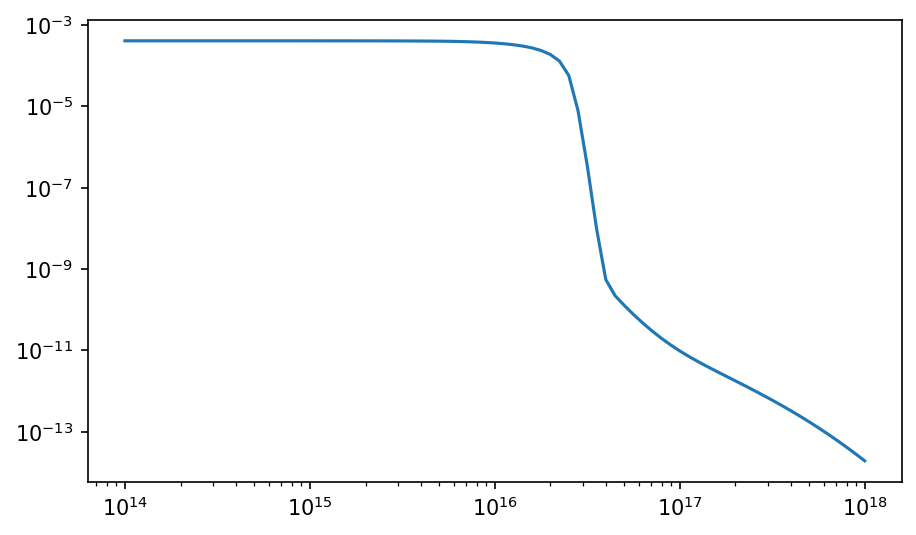

In [70]:
fig = plt.figure(figsize = (7,4))
ax1 = fig.add_subplot((111))

ax1.plot(physpar['RADIUS'], fracs)

ax1.set_xscale('log')
ax1.set_yscale('log')

plt.show()